## Current step:
Select data augmentation policies using a controller model trained with Proximal Policy Optimization reinforcement learning.  

Be sure that the model is improving with training, and policies which resulted in lower accuracy are less likely to be chosen.

# AutoAugment with Proximal Policy Optimization



In [0]:
from keras import models, layers, backend, initializers
import time

import PIL
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw

import matplotlib.pyplot as plt
import numpy as np

In [0]:
from sklearn import metrics

In [0]:
from keras import datasets
from keras.utils import to_categorical
np.random.seed(42)
(XtrainFull, ytrainFull), (Xtest, ytest) = datasets.cifar10.load_data()
ix = np.arange(len(XtrainFull))
np.random.shuffle(ix)
Xtrain = XtrainFull[ix[:2000]]
ytrain = ytrainFull[ix[:2000]]
ytrain = to_categorical(ytrain)

Xval = XtrainFull[ix[2000:4000]]
yval = ytrainFull[ix[2000:4000]]
yval = to_categorical(yval)


ytest = to_categorical(ytest)


In [0]:
imageClasses = ["airplane",
"automobile",
"bird",
"cat",
"deer",
"dog",
"frog",
"horse",
"ship",
"truck"]

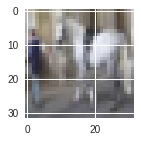

In [0]:
plt.figure(figsize=[2,2])
plt.imshow(Xtrain[0])

## Define Image Transformations

In [0]:
# Code below adapted from augmentation_transforms.py
# Modified to support transforms at the image class level
# Original copywright below:
# Copyright 2018 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
IMAGE_SIZE = 32
MEANS = [0.49139968, 0.48215841, 0.44653091]
STDS = [0.24703223, 0.24348513, 0.26158784]
PARAMETER_MAX = 10  # What is the max 'level' a transform could be predicted
#def pil_wrap(img):
#  """Convert the `img` numpy tensor to a PIL Image."""
#  return PIL.Image.fromarray(
#      np.uint8((img * STDS + MEANS) * 255.0)).convert('RGBA')
#def pil_unwrap(pil_img):
#  """Converts the PIL img to a numpy array."""
#  pic_array = (np.array(pil_img.getdata()).reshape((32, 32, 4)) / 255.0)
#  i1, i2 = np.where(pic_array[:, :, 3] == 0)
#  pic_array = (pic_array[:, :, :3] - MEANS) / STDS
#  pic_array[i1, i2] = [0, 0, 0]
#  return pic_array


def pil_wrap(X):
  X = X.reshape(32, 32, 3)
  X = np.uint8(X)
  return PIL.Image.fromarray(X)
def pil_unwrap(img):
  X = np.array(img.getdata()).reshape(32, 32, 3).astype(float)
  return X

# modified from https://github.com/rpmcruz/autoaugment/blob/master/transformations.py
def create_cutout_mask(img_height, img_width, num_channels, size):
  """Creates a zero mask used for cutout of shape `img_height` x `img_width`.
  Args:
    img_height: Height of image cutout mask will be applied to.
    img_width: Width of image cutout mask will be applied to.
    num_channels: Number of channels in the image.
    size: Size of the zeros mask.
  Returns:
    A mask of shape `img_height` x `img_width` with all ones except for a
    square of zeros of shape `size` x `size`. This mask is meant to be
    elementwise multiplied with the original image. Additionally returns
    the `upper_coord` and `lower_coord` which specify where the cutout mask
    will be applied.
  """
  assert img_height == img_width
  # Sample center where cutout mask will be applied
  height_loc = np.random.randint(low=0, high=img_height)
  width_loc = np.random.randint(low=0, high=img_width)
  # Determine upper right and lower left corners of patch
  upper_coord = (max(0, height_loc - size // 2), max(0, width_loc - size // 2))
  lower_coord = (min(img_height, height_loc + size // 2),
                 min(img_width, width_loc + size // 2))
  mask_height = lower_coord[0] - upper_coord[0]
  mask_width = lower_coord[1] - upper_coord[1]
  assert mask_height > 0
  assert mask_width > 0
  mask = np.ones((img_height, img_width, num_channels))
  zeros = np.zeros((mask_height, mask_width, num_channels))
  mask[upper_coord[0]:lower_coord[0], upper_coord[1]:lower_coord[1], :] = (
      zeros)
  return mask, upper_coord, lower_coord
def cutout_numpy(img, size=16):
  """Apply cutout with mask of shape `size` x `size` to `img`.
  The cutout operation is from the paper https://arxiv.org/abs/1708.04552.
  This operation applies a `size`x`size` mask of zeros to a random location
  within `img`.
  Args:
    img: Numpy image that cutout will be applied to.
    size: Height/width of the cutout mask that will be
  Returns:
    A numpy tensor that is the result of applying the cutout mask to `img`.
  """
  img_height, img_width, num_channels = (img.shape[0], img.shape[1],
                                         img.shape[2])
  assert len(img.shape) == 3
  mask, _, _ = create_cutout_mask(img_height, img_width, num_channels, size)
  return img * mask
def float_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .
  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled
      to level/PARAMETER_MAX.
  Returns:
    A float that results from scaling `maxval` according to `level`.
  """
  return float(level) * maxval / PARAMETER_MAX
def int_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .
  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled
      to level/PARAMETER_MAX.
  Returns:
    An int that results from scaling `maxval` according to `level`.
  """
  return int(level * maxval / PARAMETER_MAX)
def _cutout_pil_impl(pil_img, level):
  """Apply cutout to pil_img at the specified level."""
  size = int_parameter(level, 20)
  if size <= 0:
    return pil_img
  img_height, img_width, num_channels = (32, 32, 3)
  _, upper_coord, lower_coord = (
      create_cutout_mask(img_height, img_width, num_channels, size))
  pixels = pil_img.load()  # create the pixel map
  for i in range(upper_coord[0], lower_coord[0]):  # for every col:
    for j in range(upper_coord[1], lower_coord[1]):  # For every row
      pixels[i, j] = (125, 122, 113, 0)  # set the colour accordingly
  return pil_img
def _enhancer_impl(enhancer):
  """Sets level to be between 0.1 and 1.8 for ImageEnhance transforms of PIL."""
  def impl(pil_img, level):
    v = float_parameter(level, 1.8) + .1  # going to 0 just destroys it
    return enhancer(pil_img).enhance(v)
  return impl
# =============================================================================
def ShearX(img, v):  # [-0.3, 0.3]
    v = float_parameter(v, 0.3)
    if np.random.random() > 0.5:
      v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))
  
def ShearY(img, v):  # [-0.3, 0.3]
    v = float_parameter(v, 0.3)
    if np.random.random() > 0.5:
      v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))  
  
def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    v = int_parameter(v, 10)
    if np.random.random() > 0.5:
      v = -v
    return img.transform((32, 32), PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))
def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    v = int_parameter(v, 10)
    if np.random.random() > 0.5:
      v = -v
    return img.transform((32, 32), PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))
def Rotate(img, v):  # [-30, 30]
    v = int_parameter(v, 30)
    if np.random.random() > 0.5:
      v = -v
    return img.rotate(v)
def AutoContrast(img, _):
    #return PIL.ImageOps.autocontrast(img.convert('RGB')).convert('RGBA')
    return PIL.ImageOps.autocontrast(img)
def Invert(img, _):
    #return PIL.ImageOps.invert(img.convert('RGB')).convert('RGBA')
    return PIL.ImageOps.invert(img)
def Equalize(img, _):
    #return PIL.ImageOps.equalize(img.convert('RGB')).convert('RGBA')
    return PIL.ImageOps.equalize(img)
def Flip_LR(img, _):  # not from the paper
    return img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
def Flip_UD(img, _):
    return img.transpose(PIL.Image.FLIP_TOP_BOTTOM)
  
def Solarize(img, v):  # [0, 256]
    v = int_parameter(v, 256)
    #return PIL.ImageOps.solarize(img.convert('RGB'), 256 - v).convert('RGBA')
    return PIL.ImageOps.solarize(img, 256 - v)
def Posterize(img, v):  # [4, 8]
    v = int_parameter(v, 4)
    #return PIL.ImageOps.posterize(img.convert('RGB'), 4 - v).convert('RGBA')
    return PIL.ImageOps.posterize(img, 4 - v)
def Contrast(img, v):  # [0.1,1.9]
    return _enhancer_impl(PIL.ImageEnhance.Contrast)(img, v)
def Blur(img, v):
    return img.filter(PIL.ImageFilter.BLUR)
  
def Color(img, v):  # [0.1,1.9]
    return _enhancer_impl(PIL.ImageEnhance.Color)(img, v)
def Smooth(img, v):
    return img.filter(PIL.ImageFilter.SMOOTH)
  
def Brightness(img, v):  # [0.1,1.9]
    return _enhancer_impl(PIL.ImageEnhance.Brightness)(img, v)
def Sharpness(img, v):  # [0.1,1.9]
    return _enhancer_impl(PIL.ImageEnhance.Sharpness)(img, v)
def Cutout(img, v):  # [0, 60] => percentage: [0, 0.2]
    return _cutout_pil_impl(img, v)
def Crop(img, v, interpolation=PIL.Image.BILINEAR):
    cropped = img.crop((v, v, IMAGE_SIZE - v, IMAGE_SIZE - v))
    resized = cropped.resize((IMAGE_SIZE, IMAGE_SIZE), interpolation)
    return resized
def Identity(img, v):
  return img
  
opmap = {
    'Flip_LR' : Flip_LR,
    'Flip_UD' : Flip_UD,
    'AutoContrast' : AutoContrast,
    'Equalize' : Equalize,
    'Invert' : Invert,
    'Rotate' : Rotate,
    'Posterize' : Posterize,
    'Crop' : Crop,
    'Solarize' : Solarize,
    'Color' : Color,
    'Contrast' : Contrast,
    'Brightness' : Brightness,
    'Sharpness' : Sharpness,
    'ShearX' : ShearX,
    'ShearY' : ShearY,
    'TranslateX' : TranslateX,
    'TranslateY' : TranslateY,
    'Cutout' : Cutout,
    'Blur' : Blur,
    'Smooth' : Smooth,
    'Identity': Identity
    
}
transformList = list(opmap.values())

In [0]:
len(transformList)

21

## Define Operation, Subpolicy classes, autoaugment generator

In [0]:

def autoaugment(X, Y, transforms, probabilities=None, batch_size=32, nClasses=None):
  if probabilities is None:
    assert nClasses is not None
    probabilities = np.ones([nClasses, len(transforms)])
  normalizedProbs = probabilities / probabilities.sum(axis=1)[:, np.newaxis]
  while True:
      ix = np.arange(len(X))
      np.random.shuffle(ix)
      for i in range(len(X) // batch_size):
          _ix = ix[i*batch_size:(i+1)*batch_size]
          _X = X[_ix]
          _Y = Y[_ix]
          
          
          transformedX = []
          for j in range(len(_X)):
            whichClass = np.argmax(_Y[j])
            probs = normalizedProbs[whichClass]
            magnitude = np.random.choice(10)
            whichTransform = np.random.choice(transforms, p=probs)

            pilX = PIL.Image.fromarray(_X[j])
            pilX = whichTransform(pilX, magnitude)
            transformedX.append(np.array(pilX))
          yield np.array(transformedX), _Y


## Display the transformations
### (Just to see what they look like)

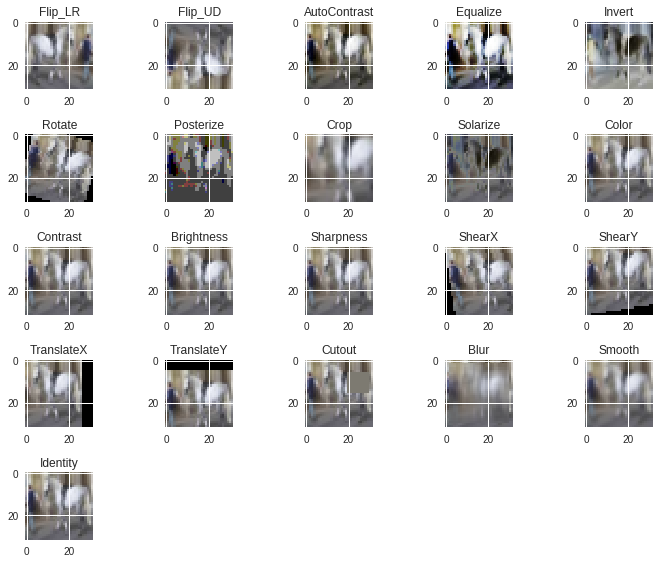

In [0]:
plt.figure(figsize=[10,8])

for i, op in enumerate(opmap):
  newX = opmap[op](PIL.Image.fromarray(Xtrain[0]), 5)
  plt.subplot(5,5, i+1)
  plt.title(op)
  plt.imshow(newX)
plt.tight_layout()

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.losses import categorical_crossentropy
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import rmsprop

class Child():
  def __init__(self, epochs=128, batchSize=500, inputShape=[32,32,3],
              num_classes=10, lr=1e-4):
    # architecture from: https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

    self.epochs = epochs
    self.batchSize = batchSize
    self.inputShape = inputShape
    self.lr = lr
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                    input_shape=inputShape, activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # initiate RMSprop optimizer
    opt = rmsprop(lr=self.lr, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                 optimizer=opt,
                 metrics=['accuracy'])
    self.model = model

  def fit(self, generator, stepsPerEpoch, verbose=0):
    self.model.fit_generator(generator,
                             steps_per_epoch = stepsPerEpoch,
                             epochs=self.epochs,
                             use_multiprocessing=False,
                             verbose=verbose)

  def evaluateByClass(self, X, Y):
    """
    Predicts Y and returns the F1 score for each image class
    """
    prediction = self.model.predict(X)
    y_pred = np.argmax(prediction, axis=1)
    y_true = np.argmax(Y, axis=1)
    
    precision, recall, fbeta, support = metrics.precision_recall_fscore_support(
                                        y_true, y_pred)
    
    return fbeta
    
  
  def evaluate(self, X, Y, verbose=0):
    """
    Returns the overall accuracy of the model on all
    passed validation data
    """
    return self.model.evaluate(X, Y, verbose=verbose)[1]
    



In [0]:
from keras import models, layers, initializers
import tensorflow as tf

    
class Controller():
  
    def __init__(self, nClasses=10, transformsPicked=None, transforms={},
                 lstmUnits=25, denseUnits=25, epochs=8,
                 minibatchSize=8, lr=1e-2, epsilon = .4,
                ):

      """
      Controller object which generates transformation policies      
      
      Consists of a neural net which takes a constant "dummy" input state
      Feeds through a LSTM, then a set of parallel dense layers with
      softmax activation.  
      
      Each image class has a softmax layer nTransforms long, from which 
      we sample transformsPicked times. The more often a transform is sampled,
      the more frequently the image class will be put through that transform
      during data augmentation

      Args:
      
      nClasses: int for how many different classes to produce probabilities for

      transformsPicked: int or None, indicating how many discrete samples to 
                        draw from each softmax probabiliites. If None, will 
                        default to the number of transforms / 2
      transforms: 
      
      lstmUnits: The output dimension of the LSTM encoder
      denseUnits: The number of nodes in a dense layer after the LSTM. Can
                  be int or None
      
      minibatchSize: How many times to sample policies and train a child model
                     before fitting
                     
      lr: Learning rate for the controller net
      
      transforms: a list image transform Operation objects

      nProbabilities: How many evenly-spaced discrete probability values will 
                      be considered: 11 means that each operation will have a 
                      0%, 10%, 20% ... 80%, 90%, or 100% of being applied.
                      
                   
      """
      
      self.nClasses = nClasses
      self.lstmUnits = lstmUnits
      self.denseUnits = denseUnits
      self.minibatchSize = minibatchSize
      self.lr = lr
      self.epochs=epochs
      self.transforms = transforms
      self.nTransforms = len(transforms)

      self.transformsPicked = transformsPicked
      if transformsPicked is None:
        self.transformsPicked = self.nTransforms // 2
      
      
      self.softmaxCache = None
      self.epsilon = tf.constant(epsilon, dtype=tf.float32)
      self.buildModel()
      
    def buildModel(self):

      """
      Builds the neural net to generate policy probabilities.
      
      Starts with a dummy state input, goes through an LSTM layer
      and a dense layer, which outputs a number of dense, softmax layers
      
      Uses Adam optimizer, and Clipped PPO
      """


      self.softmaxOutputs = []
      
      
      # *************
        
      self.input_ph = tf.keras.Input(shape=(1,1),
                                     dtype=tf.float32,
                                     name='inputLayer')

      self.lstmLayer = tf.keras.layers.CuDNNLSTM(
                            units=self.lstmUnits,
                            return_sequences=True,
                            name='controller')

      activity = self.lstmLayer(self.input_ph)
      if self.denseUnits is not None:
        activity = tf.keras.layers.Dense(self.denseUnits,
                                         activation='relu',
                                        name='hidden_dense')(activity)

      for i in range(self.nClasses):
          nextSoftmax = tf.keras.layers.Dense(self.nTransforms,
                                          activation='softmax',
                                          name='class_'+str(i))
          self.softmaxOutputs.append(nextSoftmax(activity))
          
          
      allSoftmaxes = tf.stack(self.softmaxOutputs, axis=3)
      allSoftmaxes = tf.squeeze(allSoftmaxes)
      # This is now a tensor of shape [nBatch, nTransforms, nClasses]
      
      self.sampled_ph = tf.keras.backend.placeholder(
                           shape=(self.nTransforms, self.nClasses),
                           dtype=tf.float32,
                           name='sampled_ph')
      # Indicates what proportion of transforms was chosen
      

      self.score_ph = tf.keras.backend.placeholder(shape=(1, self.nClasses),
                                                   dtype=tf.float32,
                                                  name='scores_ph')
      # [nBatch, 1, nClasses]
      

      newLogProbs = tf.reduce_sum(tf.log(allSoftmaxes) * self.sampled_ph)
      # Indicates the log probability of selecting the policy indicated
      # by self.selected_ph, according to the current softmaxes
      # shape [nBatch]
      
      
      self.prevLogProb_ph = tf.keras.backend.placeholder(shape=(1),
                                                         dtype=tf.float32,
                                                        name='prevLogPs_ph')
      
      differenceRatio = tf.exp(newLogProbs - self.prevLogProb_ph)
      
      clippedDifferenceRatio = tf.clip_by_value(differenceRatio,
                                                1-self.epsilon,
                                                1+self.epsilon)
      
      unClippedRatioScore = differenceRatio * self.score_ph
      clippedRatioScore = clippedDifferenceRatio * self.score_ph
            
      finalScore = tf.minimum(unClippedRatioScore, clippedRatioScore)
      
      loss = -tf.reduce_mean(finalScore)
      self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(loss)      

    def fit(self, selections, scores, logPs):
      """
      Fits the model based on a batch of data tuples,
      (selections, score, logPs)

      Args:
        selections: a list of nIterations arrays [nClasses, nTransforms] 
        indicating the ratio of which transforms were applied to each image class

        scores: an np.ndarray of shape [nIterations, nClasses] indicating the
        f1 score of each image class in that iteration

        logPs: a list of nIterations floats indicating the log likelihood of
        the controller producing each selection according to the softmax values
        at the time it was produced
      
      """
      
      scoreMeans = scores.mean(axis=0)
      scoreStds = scores.std(axis=0)
      normalizedScores = scores - scoreMeans
      normalizedScores = normalizedScores / scoreStds
      
      session = backend.get_session()
      assert len(selections) >= self.minibatchSize
      assert len(scores) >= self.minibatchSize
      assert len(logPs) >= self.minibatchSize
      
      for i in range(self.epochs):
#         for selection, score, logP in zip(selections,
#                                          normalizedScores,
#                                          logPs):
        for selection, score, logP in zip(selections[-self.minibatchSize:],
                                         normalizedScores[-self.minibatchSize:],
                                         logPs[-self.minibatchSize:]):
          fd = {}
          fd[self.prevLogProb_ph] = logP
          fd[self.sampled_ph] = selection.T
          fd[self.score_ph] = score
          fd[self.input_ph] = np.zeros([1,1,1])
          session.run(self.optimizer, feed_dict=fd)
      self.softmaxCache = None
      
      return self
    
    def getSoftmaxes(self):
      session = backend.get_session()
      softmaxes = session.run(self.softmaxOutputs,
                              feed_dict={self.input_ph:np.zeros([1,1,1])})
      softmaxes = [np.squeeze(s) for s in softmaxes]
      self.softmaxCache = softmaxes
      
      return softmaxes
   
    def getPolicy(self, softmaxes=None):
      """
      Using the softmax outputs from the model's current weights (or passed
      softmax), 
      Draws self.transformsPicked samples from each image's softmax 
      probabilities treating them as a multinomial distribution.
      Returns this matrix of samples and the log probability of generating
      this exact policy.
      """
      if softmaxes is None:
        if self.softmaxCache is None:
          softmaxes = self.getSoftmaxes()
        else:
          softmaxes = self.softmaxCache
      
      selections = []
      logProbs = []
      for pvalues in softmaxes:
        selections.append(np.random.multinomial(self.transformsPicked,
                                               pvals=pvalues))
        logP = np.log(pvalues)
        logProbs.append((selections[-1] * logP).sum())

      return np.array(selections), np.array(logProbs).sum()



In [0]:
print ('Preparing Controller')
tic = time.time()
controller = Controller(transforms=transformList, minibatchSize=4,
                       epochs=32, epsilon=.3, lr=3e-2)
toc = time.time()
print ("Controller ready, took %ds" % (toc-tic))



Preparing Controller
Controller ready, took 2s


In [0]:

f1Scores = []
selectedSamples = []
logProbs = []
savedSoftmaxes = []


In [0]:

for i in range(32):
  print ("Iteration %d" % i)
  softmaxes = controller.getSoftmaxes()
  savedSoftmaxes.append(softmaxes)
  
  for policySample in range(controller.minibatchSize):
    transformSample, logP = controller.getPolicy(softmaxes)
    
    logProbs.append([logP])
    selectedSamples.append(transformSample)
    
    child = Child(epochs=64, batchSize=1000)

    tic = time.time()

    aug = autoaugment(Xtrain, ytrain, transformList,
                  probabilities=transformSample, batch_size=child.batchSize)

    child.fit(aug, len(Xtrain) // child.batchSize)
    toc = time.time()

    scores = child.evaluateByClass(Xval, yval)
    print('-> Child average f1Score: %.3f (elaspsed time: %ds)' % (scores.mean(),
                                                                   (toc-tic)))
    f1Scores.append(scores)
  
  controller.fit(selectedSamples, np.array(f1Scores)[:,np.newaxis,:], np.array(logProbs))


Iteration 0


In [0]:
finalSoftmax = controller.getSoftmaxes()


In [0]:
import seaborn as sns

In [0]:
[str(t).split(' ')[1] for t in transformList]

['Flip_LR',
 'Flip_UD',
 'AutoContrast',
 'Equalize',
 'Invert',
 'Rotate',
 'Posterize',
 'Crop',
 'Solarize',
 'Color',
 'Contrast',
 'Brightness',
 'Sharpness',
 'ShearX',
 'ShearY',
 'TranslateX',
 'TranslateY',
 'Cutout',
 'Blur',
 'Smooth',
 'Identity']

In [0]:
plt.figure(figsize=[12,8])
sns.heatmap((100*finalSoftmax).astype(int), cmap='RdYlGn', center=1./len(transformList))
xt = plt.xticks(range(21), [str(t).split(' ')[1] for t in transformList], rotation=45)
yt = plt.yticks(np.arange(10)+.5, imageClasses, rotation=0)
plt.title('Learned Probability of Using Transform\nBy Image Class')

NameError: ignored

In [0]:
logSoft = np.log(np.array(savedSoftmaxes[-1]))

newP = []
meanf1Scores = []

# find how likely the controller would be to pick each policy
for i in range(len(f1Scores)):
  sample = selectedSamples[i]
  newP.append((logSoft * sample).sum())
  meanf1Scores.append(f1Scores[i].mean())
  

Text(0.5,1,'Controller Model Likelihood Of Reproducing\nAugmentation Policies vs Accuracy')

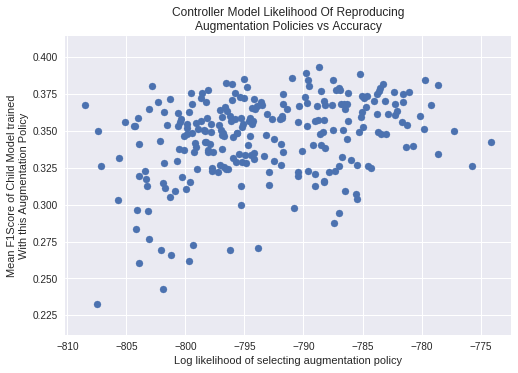

In [0]:
plt.scatter(x=newP, y=meanf1Scores)
plt.ylabel('Mean F1Score of Child Model trained\nWith this Augmentation Policy')
plt.xlabel('Log likelihood of selecting augmentation policy')
plt.title('Controller Model Likelihood Of Reproducing\nAugmentation Policies vs Accuracy')

In [0]:
np.corrcoef(newP, meanf1Scores)

array([[1.        , 0.31920682],
       [0.31920682, 1.        ]])

In [0]:
logSoft.shape

(10, 11)

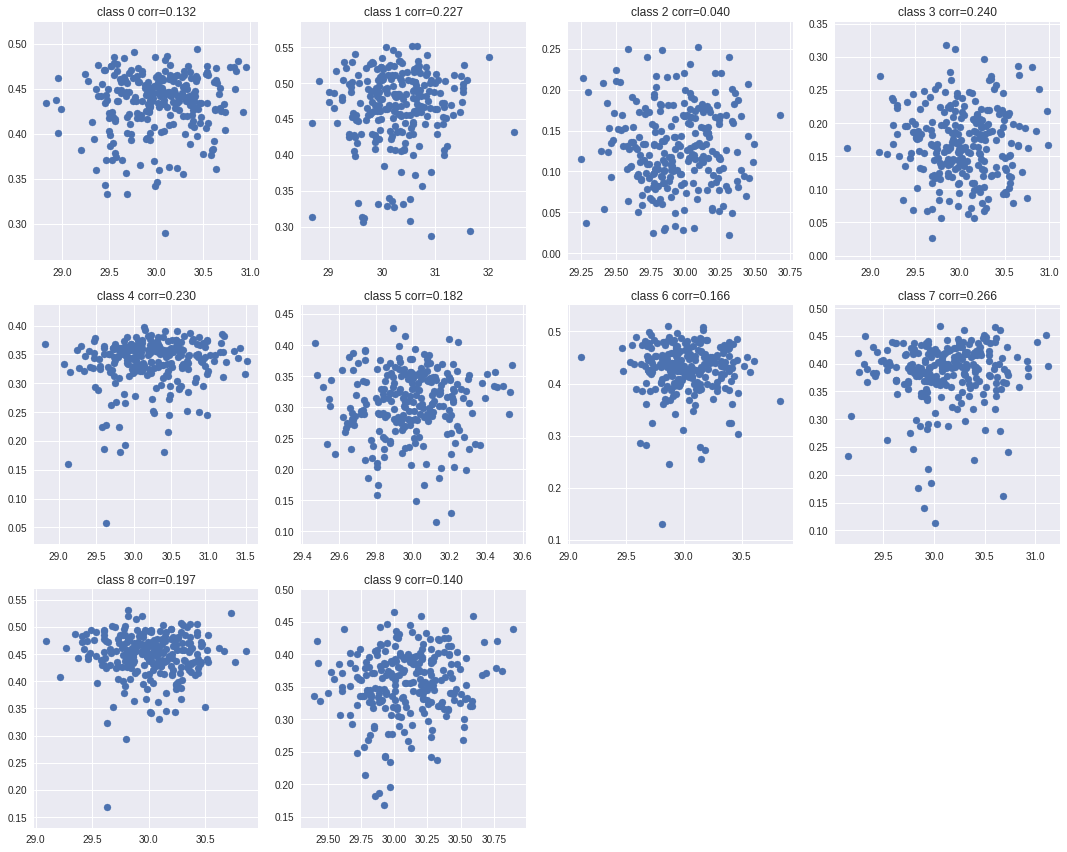

In [0]:
allScores = []
allNewP = []
plt.figure(figsize=[15,12])

for i in range(10):
  plt.subplot(3,4,i+1)
  classScores = []
  classNewP = []
  # find how likely the controller would be to pick each policy
  for j in range(len(f1Scores)):
    sample = selectedSamples[j]
    classScores.append(f1Scores[j][i])
    allScores.append(classScores[-1])
    
    classNewP.append((savedSoftmaxes[-5][i] * sample).sum())
    allNewP.append(classNewP[-1])
    
  plt.scatter(x=classNewP, y=classScores)
  correl = np.corrcoef(newP, classScores)[0,1]
  plt.title('class '+str(i)+' corr=%.3f' %correl)
plt.tight_layout()
  

Text(0.5,1,'Controller Model Likelihood Of Reproducing\nAugmentation Policies vs Accuracy')

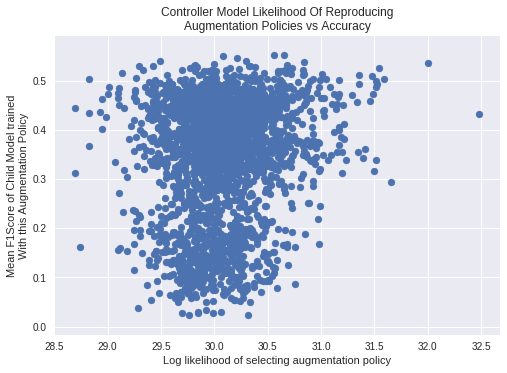

In [0]:
plt.scatter(x=allNewP, y=allScores)
plt.ylabel('Mean F1Score of Child Model trained\nWith this Augmentation Policy')
plt.xlabel('Log likelihood of selecting augmentation policy')
plt.title('Controller Model Likelihood Of Reproducing\nAugmentation Policies vs Accuracy')